# 1. Data acquisition- Earthnet


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install earthnet

In [ ]:
import earthnet as en
en.download(dataset = "earthnet2021x", split = "train", save_directory = "/content/drive/MyDrive/train")

In [ ]:
with open('/content/drive/MyDrive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/foo.txt

Hello Google Drive!

In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


In [ ]:
pip install nctoolkit

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nctoolkit as nc
import glob
import os
from tqdm import tqdm
from multiprocessing import Pool

## 1.1 View the data from one of the minicubes

In [ ]:
minicube = xr.open_dataset("/content/drive/MyDrive/train/29SND/29SND_2017-06-20_2017-11-16_2105_2233_1721_1849_32_112_26_106.nc")

In [ ]:
minicube

In [ ]:
dem = minicube['nasa_dem']
dem.data

In [ ]:
#Aggregating E-OBS data to 5-daily to match sentinel 2 data
minicube_5daily = minicube.coarsen(time = 5, coord_func = "max").mean()


In [ ]:
#minicube_on_sen2_dates
minicube = minicube.isel(time = slice(4, None, 5))
minicube

In [ ]:
print(minicube['time'])

In [ ]:
#calculate NDVI
nir = minicube.s2_B8A
red = minicube.s2_B04
mask = minicube.s2_mask

ndvi = ((nir - red) / (nir + red + 1e-8)).where(mask == 0, np.NaN)

minicube["s2_ndvi"] = ndvi

In [ ]:
ndvi.plot()

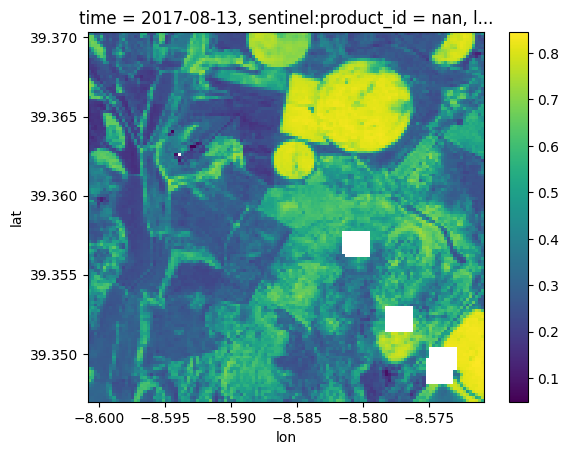

In [ ]:
ndvi_t=ndvi.isel(time=10)
ndvi_t.plot()

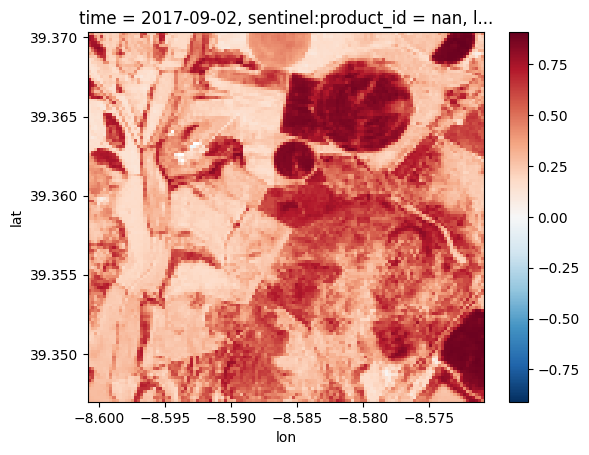

In [ ]:
ndvi_t=ndvi.isel(time=14)
ndvi_t.plot()

In [ ]:
ndvi_c=ndvi.isel(lat=94, lon=33)
ndvi_c

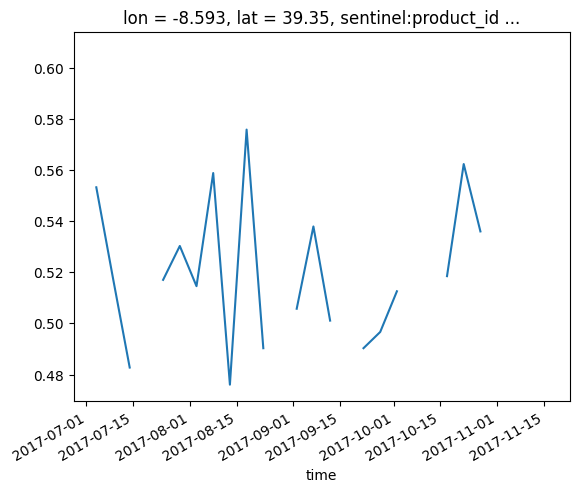

In [ ]:
ndvi_c.plot()

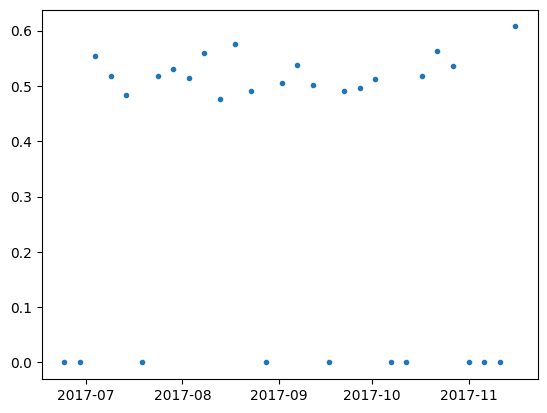

In [ ]:
ndvi_c_data = ndvi_c.data
ndvi_c_data[np.isnan(ndvi_c_data)] = 0

y = ndvi_c_data
x = ndvi.time

plt.plot(x,y,'.') 
plt.show()

## 1.2 Select one pixel and extract all variables saved in indivisual tables

In [ ]:
# NDVI
 
dir_path = r'/content/drive/MyDrive/train/'
 
# Open the text file to save the dates
output_file = open('output_NDVI.txt', 'w')
 
# Define a function to process a single file
def process_file(file):
    with xr.open_dataset(file) as minicube:
      minicube = minicube.isel(time = slice(4, None, 5))
      nir = minicube.s2_B8A
      red = minicube.s2_B04
      mask = minicube.s2_mask
  
      ndvi = ((nir - red) / (nir + red + 1e-8)).where(mask == 0,np.NaN)
      minicube["s2_ndvi"]  = ndvi
 
      ndvi_c=ndvi.isel(lat=64, lon=64)
      values = ndvi_c.values.flatten()
      return ' '.join(str(value) for value in values) + '\n'
# Loop through all the files in the directory and its subdirectories
file_list = []
for subdir, dirs, files in os.walk(dir_path):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.endswith('.nc'):
            file_list.append(filepath)
 
with Pool() as p:
    # Process the files in parallel using multiprocessing
    results = list(tqdm(p.imap(process_file, file_list), total=len(file_list), desc='Processing files'))
 
# Write the results to the output file
output_file.writelines(results)
output_file.close()

In [ ]:
# Rainfall

dir_path = r'/content/drive/MyDrive/train/'

# Open the text file to save the dates
output_file = open('output_rainfall.txt', 'w')

# Define a function to process a single file
def process_file(file):
    with xr.open_dataset(file) as minicube:
        minicube_5daily = minicube.coarsen(time=5, coord_func='max').mean()
        rainfall = minicube_5daily['eobs_tg']
        values = rainfall.values.flatten()
        return ' '.join(str(value) for value in values) + '\n'

# Loop through all the files in the directory and its subdirectories
file_list = []
for subdir, dirs, files in os.walk(dir_path):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.endswith('.nc'):
            file_list.append(filepath)

with Pool() as p:
    # Process the files in parallel using multiprocessing
    results = list(tqdm(p.imap(process_file, file_list), total=len(file_list), desc='Processing files'))

# Write the results to the output file
output_file.writelines(results)
output_file.close()


Processing files: 100%|██████████| 23816/23816 [1:29:01<00:00,  4.46it/s]


In [ ]:
# Temperature

dir_path = r'/content/drive/MyDrive/train/'

# Open the text file to save the dates
output_file = open('output_temperature.txt', 'w')

# Define a function to process a single file
def process_file(file):
    with xr.open_dataset(file) as minicube:
        minicube_5daily = minicube.coarsen(time=5, coord_func='max').mean()
        temperature = minicube_5daily['eobs_tg']
        values = temperature.values.flatten()
        return ' '.join(str(value) for value in values) + '\n'

# Loop through all the files in the directory and its subdirectories
file_list = []
for subdir, dirs, files in os.walk(dir_path):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.endswith('.nc'):
            file_list.append(filepath)

with Pool() as p:
    # Process the files in parallel using multiprocessing
    results = list(tqdm(p.imap(process_file, file_list), total=len(file_list), desc='Processing files'))

# Write the results to the output file
output_file.writelines(results)
output_file.close()

In [ ]:
# DEM

dir_path = r'/content/drive/MyDrive/train/'

# Load all the netCDF files into a single xarray dataset
dataset = xr.open_mfdataset(os.path.join(dir_path, '**/*.nc'))

# Extract the time slice you want and flatten the data
dem_c = dataset['nasa_dem'].isel(lat=64, lon=64)

# Open the text file to save the data
output_file = open('output_dem.txt', 'w')

# Loop through the flattened data, write it to the output file, and track progress with tqdm
with output_file as f, tqdm(desc='Processing data', total=len(dem_c.values.flatten())) as pbar:
    for value in dem_c.values.flatten():
        f.write(str(value) + ' ')
        pbar.update(1)

# Close the output file
output_file.close()

In [ ]:
# Dates

dir_path = r'/content/drive/MyDrive/train/'

# Open the text file to save the dates
output_file = open('output_dates.txt', 'w')

# Loop through all the files in the directory and its subdirectories
file_list = []
for subdir, dirs, files in os.walk(dir_path):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.endswith('.nc'):
            file_list.append(filepath)

for file in tqdm(file_list, desc='Processing files'):
    # Open the netCDF file and extract the time coordinate
    with xr.open_dataset(file) as minicube:
        minicube = minicube.isel(time = slice(4, None, 5))
        time = minicube.time.values.astype('M8[D]').tolist()

        # Write the time coordinate to the output file
        output_file.write(' '.join(str(date) for date in time) + '\n')
        
output_file.close()

output_file_path = os.path.join(dir_path, 'output_dates.txt')
print(output_file_path)
